# Defining Prediction Tasks for Biomedical Text Mining

In [1]:
import json
import pandas as pd

# processed to JSON format
data_dir = "./baseline/data"

## Loading PubMed Toxicogenomics Dataset

In [2]:
# PubMed training dataset from PubTator
with open(data_dir + "/train.json") as f:
    train_json = json.loads(f.read())

# validation split of 1521 examples (2%)
with open(data_dir + "/valid.json") as f:
    valid_json = json.loads(f.read())

# manually curated by biologists (1939)
with open(data_dir + "/test.json") as f:
    test_json = json.loads(f.read())

In [4]:
for doc in valid_json:
    title_length = len(doc['title'])
    for entity in doc['entity']:
        entity['label'] = entity.pop('type')

for doc in test_json:
    title_length = len(doc['title'])
    for entity in doc['entity']:
        entity['label'] = entity.pop('type')

In [27]:
# toxicogenomics interactions that are annotated in the dataset 
relation_map = json.loads(open(data_dir + "/relation_map.json").read())
relation_map

{'chem_disease:marker/mechanism': 0,
 'chem_disease:therapeutic': 1,
 'chem_gene:increases^expression': 2,
 'chem_gene:decreases^expression': 3,
 'gene_disease:marker/mechanism': 4,
 'chem_gene:increases^activity': 5,
 'chem_gene:decreases^activity': 6,
 'chem_gene:increases^metabolic_processing': 7,
 'chem_gene:affects^binding': 8,
 'chem_gene:increases^transport': 9,
 'chem_gene:decreases^metabolic_processing': 10,
 'chem_gene:affects^localization': 11,
 'chem_gene:affects^expression': 12,
 'gene_disease:therapeutic': 13}

## Entity Recognition

In [ ]:
import spacy
# try a new tokenizer for science
nlp = spacy.load("en_core_sci_sm")
doc = nlp(train_json[1]['abstract'])

In [29]:
from spacy import displacy

doc = valid_json[10] # select

doc_dict = {
    "title": doc['title'],
    "text": doc['title']+" "+doc['abstract'],
    "ents": doc['entity']
    }

entity_colors = {
    "Chemical": "#E9DF85", "Disease": "#ff6961", "Gene": "#85C1E9"
    }

displacy.render(doc_dict, manual=True, style="ent",
                 options={"colors": entity_colors})

In [6]:
doc['relation']

[{'type': 'chem_gene:increases^expression',
  'subj': 'MESH:C517827',
  'obj': '1543'},
 {'type': 'chem_gene:affects^binding', 'subj': 'MESH:C517827', 'obj': '196'},
 {'type': 'chem_gene:increases^activity',
  'subj': 'MESH:C517827',
  'obj': '196'},
 {'type': 'chem_gene:affects^binding', 'subj': 'MESH:C517827', 'obj': '2099'}]

## Relation Extraction

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

source, target, relations = [], [], []

for item in doc['relation']:
    source.append(item['subj'])
    target.append(item['obj'])
    relations.append(item['type'])

# constructing a knowledge graph on the relations in the document
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [8]:
kg_df

,source,target,edge
0,MESH:C517827,1543,chem_gene:increases^expression
1,MESH:C517827,196,chem_gene:affects^binding
2,MESH:C517827,196,chem_gene:increases^activity
3,MESH:C517827,2099,chem_gene:affects^binding


In [9]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [11]:
G.nodes

NodeView(('MESH:C517827', '1543', '196', '2099'))

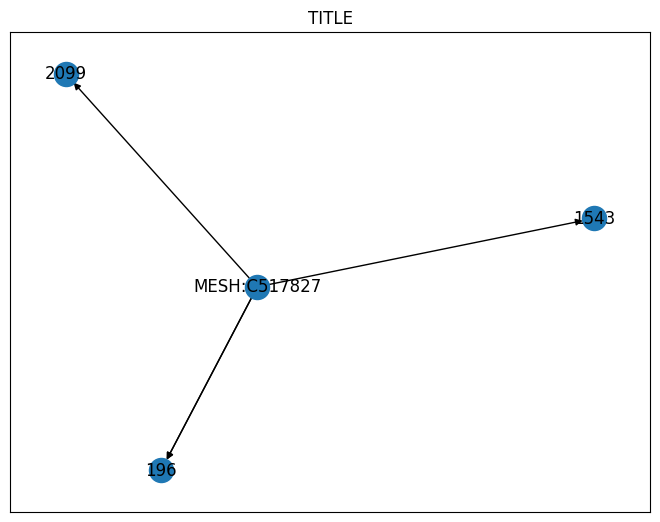

In [25]:
pos = nx.spring_layout(G, seed=42)

nx.draw(G, with_labels=True, pos=pos)
plt.title('TITLE')
plt.axis('on')

plt.show()